# Video time segmentation

In this notebook, you will take apart a video to reveal useful _time segments_.  This will enable you to analyze and search for points in time or clips within a video and reuse parts of the video for new purposes as you work on the use cases later in this workshop. 

You'll decompose a video into smaller segments using Amazon Rekognition, Amazon Transcribe and Titan Multi-modal Embeddings on Amazon Bedrock. Segmenting a video is an important _data preparation_ step to prepare the video for contextual analysis and automated workflows that require identifying video clips or points in time inside the video.  You'll be working on both the visual and audio parts of the video.  You'll break down the video into frames, shots, and scenes.  Likewise, you'll break down the audio into a transcript (words and punctuation), sentences and topics.  Finally, you will combine the topics from the audio and the scenes from the video to create chapters.  In the end, you will have an exploded structure of the video that you can use as inputs to Foundation Models on Amazon Bedrock to further understand what is happening in the video content. 

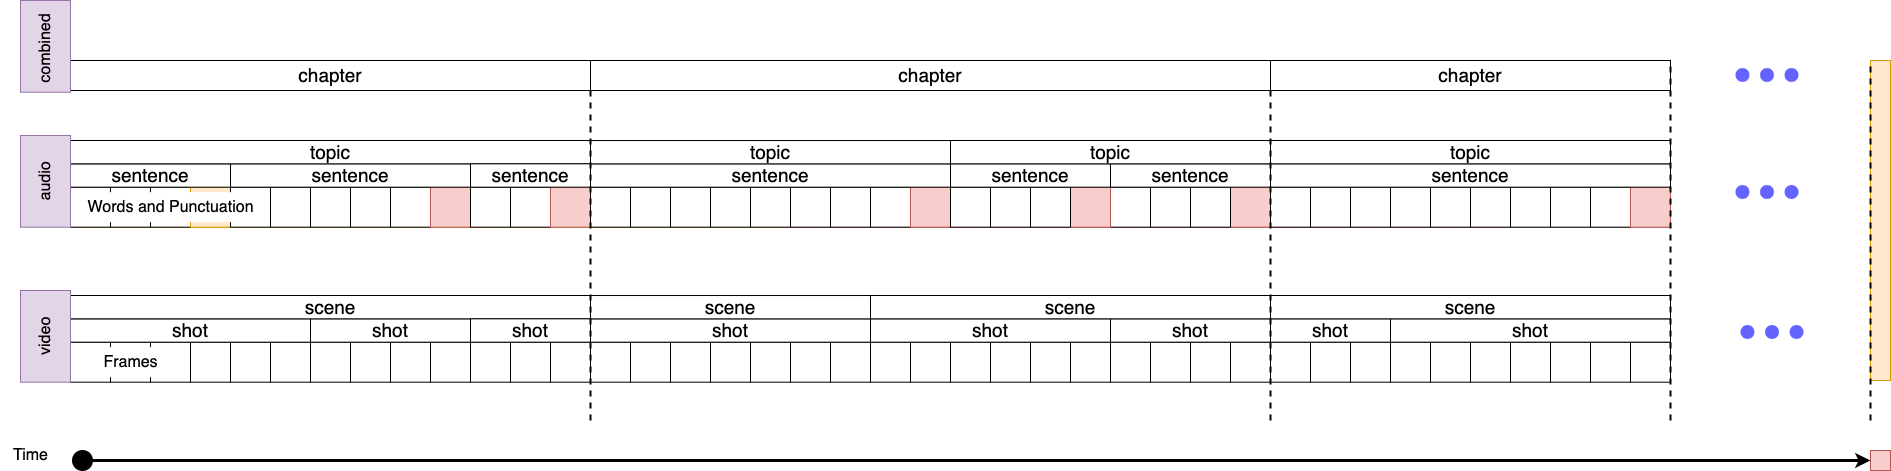
***Figure:** Video file decomposed into time segments*

The outputs of this notebook will be used in the use case sections later on in this workshop.  For example, Ad Break Detection and Contextual Ad Placement, Video Summarization, and more.

<br/><br/>

<div class="alert alert-block alert-info">
💡 In an automated workflow, these audio and video segmentation tasks can be run in parallel since there is no dependency between the steps.
</div>

<div class="alert alert-block alert-info">
💡 Video segmentation can be done along the temporal dimension or along the spatial dimension.  In the context of this notebook, the term “segmentation” will always be <i>time segmentation</i>.
</div>

### Key terms and definitions

You can refer back to this section if you want the definition the terms used in the notebook.

- **Frame** - frame image extracted from the video content
- **Shot** - continuous sequences of frames between two edits or cuts that defines one action
- **Scene** - continuous sequence of action taking place in a specific location and time, consisting of a series of shots.
- **Transcript** - continuous sequence of words and punctuation representing the speech content of the audio track in a video.
- **Sentence** - a full sentence in the English language.
- **Subtitle** - a segment of text representing the speech in a video that is meant to be displayed for viewers as they watch the video.  
- **Conversation topic (aka topic)** - A summarization of a group of sentences that contain discussion about a similar topic.
- **Chapter** - logical divisions of the storyline of the video content, consisting of a series of shots and conversations on the similar topic
- **WebVTT** - a file format used to store timed text track data, such as subtitles or captions, for video content on the web.
- **Frame accurate timestamp** - a timestamp that can be mapped to a specific frame.  Frame accurate timestamps are useful for synchronization of video elements

### Steps

1. Prerequisites
3. Extract frames from the video and create some basic frame metadata
4. Detect shots
5. Detect scenes
6. Convert speech in the video to a text transcript and subtitles
7. Detect sentences in the transcript
8. Detect conversation topics
9. Detect chapters in the video narrative using both visual and audio inputs

<div class="alert alert-block alert-info">
💡 Click on the list icon (<img src="video-understanding-with-generative-ai-on-aws-main/static/icons/list-solid.svg" alt="list icon" width="15" height="15">) in the left navigation panel in this Jupyter notebook to see the outline of the notebook and where you currently are.
</div>

Now, let's build!



## Prerequisites

### Import python packages

In [1]:
from pathlib import Path
import os
import json
import json
import boto3
import json_repair
from termcolor import colored
from IPython.display import JSON
from IPython.display import Video
from IPython.display import Pretty
from IPython.display import Image as DisplayImage
from lib.frames import VideoFrames
from lib.shots import Shots
from lib.scenes import Scenes
from lib.transcript import Transcript

### Retrieve saved values from previous notebooks

To run this notebook, you need to have run the previous notebook: [00_prerequisites.ipynb](./00-prequisites.ipynb), where you installed package dependencies and gathered some information from the SageMaker environment.

In [2]:
# Get variables from the previous notebook
%store -r

### Download the sample video, Meridian, from Netflix

The open source content is available under the [Creative Commons Attribution 4.0 International Public License](https://creativecommons.org/licenses/by/4.0/legalcode)

In [ ]:
# Save information about the video in a dictionary as we progress through the notebook
video = {}
video["mp4_file"] = 'Netflix_Open_Content_Meridian.mp4'
video["video_dir"] = Path(video["mp4_file"]).stem
video["url"] = f"https://dx2y1cac29mt3.cloudfront.net/mp4/netflix/{video['mp4_file']}"


!curl {video["url"]} -o {video["mp4_file"]}

#Video(video["mp4_file"], width=640, height=360)
Video(url=video["url"], width=640, height=360, html_attributes="controls muted autoplay")

## Visual segmentation

### Extract frames from the video and create frame metadata

In this step, you will first sample one frame per second from the video and store the frames locally in a folder with the name of the video. We chose one frame per second for downsampling based on experiences, but this can be calibrated if you have high-motion, high-frame-rate videos. 

You'll be using a Python package, [_VideoFrames_](./lib/frames.py), to work with the video at the frame level.  This package is available on GitHub.  When you call the main method of VideoFrames, it will do the following steps to help prepare the video for frame based analysis with machine learning:

1. Extract frames from the video, sampling at the specified frame rate, and store the resulting images in the folder `./<video name>/frames/`. 
2. Calculate metadata for each frame that we can use downstream in our workflow:
* **laplacian_variance** — The _Laplacian variance_ is a metric to measure the level of detail or conversely the level of blurring in a frame.  This is useful when you want to select frames that have clear details for analysis.  Media2Cloud V4 uses the Laplacian variance combined with the _perceptual hash_ of images (see below) in its Dynamic Frame Analysis feature to reduce the number of frames that need to be processed using AWS AI/ML APIs.  This can reduce the cost of frame base analysis workflows by up to 80%.
* **laplacian_image** — this is a visualization of the Laplacian variance for each image.  While it is not used in any workflow, it can help to understand what the Laplacian is.
* **perceptual_hash** — The _perceptual hash_ is a type of image encoding that creates a numerical representation that retains perceptual properties of the image.  Perceptual hashes are similar to embeddings.  They are useful when you need a fast, inexpensive way to make rough comparisons of images for similarity.
* **titan_multimodal_embedding** — Amazon Titan Multimodal Embeddings enable you to encode images, text, or both into the same embedding spaces.  Embedding can be used to cluster items by similarity.  You can use these embeddings to implement use cases such as image search, natural language search for images and multi-modal RAG.
* **timestamp_millis** — the timestamp, in milliseconds, where the frame appears in the video.  We'll use this timestamp to related video analysis results back to the video timeline.
* **similar_frames** — a list of frame IDs that are similar to this frame.  Shot detection and scene detection involve grouping frames by similarity.  We pre-compute similar frames here since we will be reusing the result several times in this workflow.  
3. Create a local vector index and populate it with the Titan Multimodal Embeddings for the frame collection so they can be searched efficiently. Frame similarity is calculated using Titan Multimodal Embeddings for the frame.
4. Upload the video to S3 so it is available to API calls that need the video inputs stored in S3.
4. Collect structural information about the video package such as time codes, number, and type of tracks and encoding information.

Let's give it a try.

In [ ]:
# extract frames from the video 
video["frames"] = VideoFrames(video["mp4_file"], session['bucket'], max_res=(392, 220), sample_rate_fps=1, force=False)

Now, let's display the a few items in resulting list of frames.  You can click on the triangle icons next to each returned attribute to examine the contents.  
Make sure to look at least one frame to see the metadata we have collected to far.

In [ ]:
display(JSON(video["frames"].frames[0:10], root="frames"))
# display all items
#display(JSON(video["frames"].frames, root="frames"))


Next, let's visualize the first 100 frames of the video.  Create a composite image that is a grid of the first 100 frames in the video, displayed from left to right and top to bottom.  

🤔 Do you notice any visual patterns in the first 100 frames?  


#### Visualize the extracted frames

In [6]:
# Create a composite image that is a grid of the first 100 frames in the video displayed from left to right and top to bottom
composite_file_name = \
    os.path.basename(video["frames"].frames[0]["image_file"]).split(".")[0] \
    + os.path.basename(video["frames"].frames[99]["image_file"]).split(".")[0] \
    + '.jpg'
first100frames_composite_image = video["frames"].composite_image(0, 100, 10) # creates a grid of images from 0-100 in 10 columns

In [ ]:
first100frames_composite_image

In [ ]:
# Display the composite image 
DisplayImage(filename=first100frames_composite_image) 

### Detect shots

From the frame grid above, you'll notice that the video contains groups of frames in sequence that are similar.   This is because they were taken from the same camera angle as a single shot.  Shots are a useful building block for video processing workflows when you need to break the video into segments for search, clipping and other types of analysis. 

In the next step, we are going to use Amazon Rekognition to automatically detect the boundaries between the shots in the video. We will use a Python library, [_Shots_](./lib/shots.py) to implement this step.  When you call `Shots`, it will do the following:

1. Use Amazon Rekognition [Detect Segments API](https://docs.aws.amazon.com/rekognition/latest/dg/segment-api.html) to find all of the shots in the video.  Each shot has a starting timestamp, and ending timestamp.  Timestamps returned by this API are _frame accurate_, meaning they are accurate to a time code for a specific frame.  Frame accuracy ensures the timestamps can reliably be used for synchronization in video editing workflows. 
2. Group the frames of the video by shots.  This will be convenient if we want to work on the frames of the video at the shot level.
3. Create a composite image of the shot.  We'll be using these composite images as prompt inputs to inputs to foundation models when we start to analyze the videos on a segment by segment basis in the next section of this workshop.

There are several other options to the Shots library we are not using, that you may be interested to explore after the workshop.

1. Use Amazon Titan Multi-modal embeddings to detect shots by passing `method=TitanMultimodalEmbeddings`.  Shots are composed of groups of similar frames.  We can use embeddings to compare similarity of the frames using a threshold to determine if they should be grouped together.  Using embeddings instead of Rekognition may be lower cost, especially if you are using embeddings for other purposes.
2. Reduce the number of frames in each shot to lower the cost of downstream processing by passing `filter=Laplcian, threshold=.15`.  Because the frames in shots are similar, analysis of frames will likely yield similar outputs.  You can lower cost by using _dynamic frame sampling_.  Dynamic frame sampling orders the frames by how much details they have (using the Laplacian variance calculated by the `Frames` method), then compares the highest detail frames to lower detail frame.  If they are similar, the lower detail frame is removed.

🤔 While the shot detection is running, try to guess how many shots Amazon Rekognition will find in the first 100 frames.

In [ ]:
video["shots"] = Shots(video["frames"], method="RekognitionShots", force=False)

Take a moment to examine the output of the `Shots` method.  

* **`rekognition_shots`** is the raw output of the Rekognition Segment Detection API.
* **`shots`** is a list of all the shots in the video.  We'll dive deeper into this output in the next few steps.
* **`shots_with_no_frames`** are shots that are shorter than our sampling interval (1 frame per second), so no frames were sampled in that shot.  

In [ ]:
display(JSON(video["shots"].__dict__, root="shots"))

#### Visualize the shots

Now let's visualize some shots using the generated composite images.  We'll look at the composite images for the first 25 shots of the video.  

<div class="alert alert-block alert-info">
💡 Use the scroll bar in the output box to view the first 25 shots.
</div>

🤔 Did you guess correctly about how many shots are in the first 100 frames?

In [ ]:
STOP = 25
for counter, shot in enumerate(video["shots"].shots):
    print(f'Shot {counter} =======')
    for image_file in shot['composite_images']:
        print(image_file['file'])
        display(DisplayImage(filename=image_file['file']) )
    if counter == STOP:
        break

Finally, let's play a couple of adjacent shots and observe how they will look as a video clip.  Play `shot[12]`.  

In [ ]:
start = video['shots'].shots[12]['start_ms']/1000
end = video['shots'].shots[12]['end_ms']/1000
shot_url = f'{video["url"]}#t={start},{end}'
Video(url=shot_url, width=640, height=360)

Play `shot[13]`

In [ ]:
start = video['shots'].shots[13]['start_ms']/1000
end = video['shots'].shots[13]['end_ms']/1000
shot_url = f'{video["url"]}#t={start},{end}'
Video(url=shot_url, width=640, height=360)

🤔 As, you can see, the two shots show the same two people in the same room having a conversation that spans the shots.  In the next section, we'll group shots together based on the visual information to get a more holistic view of the scene.

### Detect Scenes

Even after identifying individual camera shots, there may still be too many semantically similar shots depicting the same setting. To further cluster these into distinct scenes, we need to expand our frame comparison beyond just adjacent frames. By looking at similar frames across an expanded time window, we can identify shots that are likely part of the same contiguous scene. We calculate pairwise similarity scores between all frames within a given time window. Frames with similarity scores above a certain threshold are considered part of the same scene group. This process is performed recursively across all frames in a shot. The time window size and similarity threshold are calibrated parameters that can significantly impact scene boundary detection accuracy. In our example, we found a 3-minute time window and 0.85 similarity threshold gave the best scene clustering results across our video samples.

This scene grouping process is accomplished by first indexing all video frames using TME again and storing the embeddings along with their shot information and timestamps into a vector database, as illustrated in the figure below.  For this notebook, we are using a FAIS vector store to manage embedding locally, but you can use any vector store.  The implementation in Solution Guidance for Media2Cloud on AWS uses Amazon Open Search Serverless for this purpose.

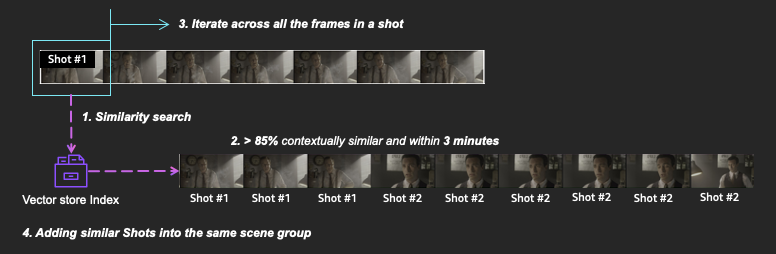

In [ ]:
video['scenes'] = Scenes(video['frames'], video['shots'].shots)

In [ ]:
#inspect the output of the Scene detection
display(JSON(video['scenes'].scenes))

#### Visualize the scenes

Now let's visualize some scenes using the generated composite images. Note that some scenes will have more than one composite image.

<div class="alert alert-block alert-info">
💡 Use the scroll bar in the output box to view the scenes.  Some scenes contain more frames than can fit on a single composite image, so the may be multiple composite images displayed for each scene.
</div>

🤔 Do you think the scenes grouped the shots in a way that makes sense?  Is there anything you would want to change?

In [ ]:
# visualize the scenes
STOP=10
for counter, scene in enumerate(video["scenes"].scenes):
    print(f'\nScene {counter}: frames {scene["start_frame_id"] } to {scene["end_frame_id"] } =======\n')
    for image_file in scene['composite_images']:
        print(image_file['file'])
        display(DisplayImage(filename=image_file['file'], height=200))
        #display(Image('image.png', height=400))
    if counter == STOP:
        break

Finally, let's play a couple of adjacent scenes and observe how they will look as a video clips. As you play the video segments, pay attention to the transition of the _video and the audio_ from one scene to the next.

In [ ]:
start_scene = 9
start = video['scenes'].scenes[start_scene]['start_ms']/1000
end = video['scenes'].scenes[start_scene]['end_ms']/1000
print(f"scene { start_scene } duration: {video['scenes'].scenes[start_scene]['duration_ms']/1000} seconds\n")
print(f"start time: { start } end time: {end} seconds\n")
shot_url = f'{video["url"]}#t={start},{end}'
Video(url=shot_url, width=640, height=360)

Play the next scene.

In [ ]:
start_scene = start_scene + 1
start = video['scenes'].scenes[start_scene]['start_ms']/1000
end = video['scenes'].scenes[start_scene]['end_ms']/1000
print(f"scene { start_scene } duration: {video['scenes'].scenes[start_scene]['duration_ms']/1000} seconds\n")
print(f"start time: { start } end time: {end} seconds\n")
shot_url = f'{video["url"]}#t={start},{end}'
Video(url=shot_url, width=640, height=360)


🤔 We just played scenes 9 and 10.  You may have noticed that the scene changed on a visual cue when the focus of the video turns towards the beach and the ocean.  _However_, this scene change occurs in the middle of the audio of the police dispatcher speaking over the radio.  If we want to make a cut in the video, we should probably consider not only the visual content but the audio as well. That's exactly where we're headed in the next section.

## Audio segmentation

### Generate a transcript, audio segments and WebVTT subtitles using Amazon Transcribe

In [ ]:
video['transcript'] = Transcript(video["mp4_file"], session['bucket'])

In [ ]:
JSON(video['transcript'].__dict__)

In [ ]:
JSON(video['transcript'].transcript)

#### Examine the results from Amazon Transcribe
The response from Amazon Transcribe contains a results dictionary with a transcript that contains a text-only transcript and a collection of items which contain each word and punctuation in the transcript along with a confidence score and timestamp for the item. The response also contains the same transcript formatted as subtitles in either WebVTT or SRT format. Let's take a look at these outputs.

We will be using the WebVTT output for our workflow.

##### Transcript JSON output

The transcript `results` attribute contains several interesting and useful outputs:
* **transcripts** - are a list of alternative text only transcripts for the video.  Our results is only configured to generate 1 alternative, but you can configure Amazon Transcribe to produce more, if needed.  Alternatives are just different semantic interpretations of the speech in the video.
* **items** - items is a time series of `pronunciations` (aka words) and `puntuation` that Amazon Transcribe inferred from the speech in the video.  Because this is AI inference, there is a confidence score for each item. Finally, there is a start and end time for each item, which can use to align timing of the items with other timestamped elements of the video.
* **audio_segments** - audio segments contains a list of sentences or phrases Amazon Transcribe inferred from the Speech in the video. We'll refer to audio segments interchangeably as sentences within this workshop.  Because this is natural language, speech to text doesn't always contain proper sentence, thus the more general term used by Amazon Transcribe.

Take a moment to examine each of these attributes from the sample video below.

In [ ]:
JSON(filename=video['transcript'].transcript_file)

**WebVTT Subtitles**

Let's take a look at the first few lines of the WebVTT formatted subtitles generated by Amazon Transcribe.  WebVTT subtitles can be used in video players to display the speech in the video as text on the screen.

In [ ]:
!head {video['transcript'].vtt_file}

Finally, let's view the video with the generated subtitle track.  Note: we used the shot information to start the video at the shot where the first speech occurs in the video.

In [ ]:
# Play the video with subtitles

from IPython.display import HTML
from base64 import b64encode
start = video['shots'].shots[8]['start_ms']/1000
end = video['shots'].shots[8]['end_ms']/1000
speech_shot_url = f'{video["url"]}#t={start}'

video_html = f"""
<video width="640" height="360" controls>
    <source src="{speech_shot_url}" type="video/mp4">
    <track src="{video['transcript'].vtt_file}" kind="captions" srclang="en" label="English" default>
</video>
"""

HTML(video_html)

So far, you have used fairly basic building blocks such as the structural information in the video from FFmpeg,  similarity of frames, and English language syntax from speech to text processing, to create time based segments of video.  In the next section, you will finally start to perform semantic analysis, or _video understanding_, to create segments using the ideas expressed in the video content.

### Segmentation by conversation topics using Amazon Bedrock

In this next section, you will use generative AI to understand the conversation topics that are occurring over time in the video transcript.  This is a text summarization task that can be performed by several Foundation Models.  

<div class="alert alert-block alert-info">
💡 We'll be using Anthropic Claude Sonnet 3.5 on Amazon Bedrock for this and all the other generative AI tasks throughout this workshop.  We chose Anthropic Claude Sonnet 3.5 because of its flexibility to perform a variety of tasks on multimodal (image and text) inputs.  In practice, you may want to substitute different FMs for different tasks based on your requirements.  For example, you may find that Anthropic Claude Haiku produces adequate results at a lower price points for a specific use case.
</div>

You will pass the transcript to the Anthropic Claude 3 Sonnet model on Amazon Bedrock. The model analyzes the transcript and suggests conversational topic points in a specific JSON format. In the prompt, you specify that each topic should contain a start and end timestamp along with a reason describing the topic. The prompts for the Sonnet model are shown below.  Note that this prompt uses the [Anthropic Claude Messages API](https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-anthropic-claude-messages.html):

**System prompt**

```
You are a media operation assistant who analyses movie transcripts in WebVTT 
format and suggest topic points based on the topic changes in the conversations. 
It is important to read the entire transcripts.
```


**Messages**

```
[
    {
        'content': 'Here is the transcripts in <transcript> tag:\n'
                '<transcript>{transcript}\n</transcript>\n',
        'role': 'user'
    },
    {
        'content': 'OK. I got the transcript. What output format?',
        'role': 'assistant'
    },
    {
        'content': 'JSON format. An example of the output:\n'
                '{"topics": [{"start": "00:00:10.000", "end": "00:00:32.000", '
                '"reason": "It appears the topic talks about..."}]}\n',
        'role': 'user'
    },
    {
        'content': '{', 'role': 'assistant'
    }
 ]
```

<div class="alert alert-block alert-info">
❓ <b>Ask Amazon Q Developer</b>: What are the inputs for the Anthropic Claude Messages API?
</div>

#### The code below constructs the prompt for Amazon Bedrock and then calls the Amazon Bedrock API to execute the prompt.

In [25]:
from lib import bedrock_helper as brh
from lib import util

MODEL_ID = 'anthropic.claude-3-haiku-20240307-v1:0'
MODEL_VER = 'bedrock-2023-05-31'
CLAUDE_PRICING = (0.00025, 0.00125)

def analyze_conversations(vtt_file):

    response = {}
    messages = []

    # transcript
    transcript_message = make_transcript(vtt_file)
    messages.append(transcript_message)

    # output format?
    messages.append({
        'role': 'assistant',
        'content': 'Got the transcript. What output format?'
    })

    # example output
    example_message = make_conversation_example()
    messages.append(example_message)

    # prefill output
    messages.append({
        'role': 'assistant',
        'content': '{'
    })

    ## system prompt to role play
    system = 'You are a media operation assistant who analyses movie transcripts in WebVTT format and suggest topic points based on the topic changes in the conversations. It is important to read the entire transcripts.'

    ## setting up the model params
    model_params = {
        'anthropic_version': MODEL_VER,
        'max_tokens': 4096,
        'temperature': 0.1,
        'top_p': 0.7,
        'top_k': 20,
        'stop_sequences': ['\n\nHuman:'],
        'system': system,
        'messages': messages
    }

    response['model_params'] = model_params
    try:
        response['response'] = brh.inference(model_params)
    except Exception as e:
        print(colored(f"ERR: inference: {str(e)}\n RETRY...", 'red'))
        response['response'] = brh.inference(model_params)
    return response



def make_conversation_example():
    example = {
        'topics': [
            {
                'start': '00:00:10.000',
                'end': '00:00:32.000',
                'reason': 'It appears the topic talks about...'
            }
        ]
    }

    return {
        'role': 'user',
        'content': 'JSON format. An example of the output:\n{0}\n'.format(json.dumps(example))
    }

def make_transcript(vtt_file):
    with open(vtt_file, encoding="utf-8") as f:
        transcript = f.read()
    
    return {
        'role': 'user',
        'content': 'Here is the transcripts in <transcript> tag:\n<transcript>{0}\n</transcript>\n'.format(transcript)
    }

def make_conversation_message(text):
    message = {
        'role': 'user',
        'content': 'No conversation.'
    }

    if text:
        message['content'] = 'Here is the conversation of the scene in <conversation> tag.\n<conversation>\n{0}\n</conversation>\n'.format(text)

    return message

def chapters_to_vtt(chapters, output_file):
    """
      Constructs a webvtt caption file based on the timestamps from the given chapters.
      Args:
         chapters - the topic points
         output_file - output file where the caption webvtt content is stored.
      Returns:
         None
    """
    vtt_lines = 'WEBVTT\n\n'
    for idx, chapter in enumerate(chapters):
        line = f"{idx}\n{chapter['start']} --> {chapter['end']}\n{chapter['reason']}\n"
        vtt_lines = vtt_lines+line

    util.save_to_file(output_file, vtt_lines)
    return

#### Execute the prompt and examine the output

The model will return a result formatted the way that was specified using sample output in the prompt `messages`.  In this case it is a list of topics in the video.  Each topic has:

* **start** - the start time of the topic relative to the start of the video in HH:MM:SS.MS format
* **end** - the start time of the topic relative to the start of the video in HH:MM:SS.MS format
* **reason** - the summary of the conversation in the time range between `start` and `end`

Run the next cells to execute the prompt and look at the resulting topics.

In [26]:
conversations_response = analyze_conversations(video['transcript'].vtt_file)
video['topics'] = conversations_response['response']['content'][0]['json']['topics']

# show the conversation cost
# conversation_cost = brh.display_conversation_cost(conversations_response['response'])

In [ ]:
display(JSON(video['topics'], root='topics'))

#### Finally, let's take one last look at the actual prompt passed to Anthropic Claude with all the parameters filled in.

The `system` prompt outlines the task and constraints for the Anthropic Claude, while the `messages` part of the prompt, model a conversation with the FM.  

In [ ]:
JSON(conversations_response['model_params'], root='prompt')

### Generate "topic points" 

To ensure the model's output accurately reflects the original transcript, the output JSON is post-processed to merge any overlapping chapter timestamps and align the chapter boundaries with the actual caption timestamps from the WebVTT file. 

In [29]:
%load_ext autoreload
%autoreload 2

In [ ]:
from lib import topics
## parse the conversation
#conversations = video['topics']

## merge overlapped conversation timestamps
video['topics'] = topics.merge_topics(video['topics'])

## validate the conversation timestamps against the caption timestamps
captions = topics.parse_webvtt(video['transcript'].vtt_file)
video['topics'] = topics.validate_timestamps(video['topics'], captions)

## save the conversations
util.save_to_file(os.path.join('./Netflix_Open_Content_Meridian', 'topics.json'), video['topics'])

In [ ]:
JSON(video['topics'], root='topics')

#### Visualize the topics
Finally, visualize the topics with the video.  We'll output the chapter summaries as a WebVTT file and play them with the video.

In [32]:
video['topics_vtt'] = os.path.join(video['frames'].video_asset_dir(), "topics.vtt")
chapters_to_vtt(video['topics'], video['topics_vtt'])

In [ ]:
# Play the video with topic summaries

from IPython.display import HTML
from base64 import b64encode
start = video['shots'].shots[8]['start_ms']/1000
end = video['shots'].shots[8]['end_ms']/1000
speech_shot_url = f'{video["url"]}#t={start}'

video_html = f"""
<video width="640" height="360" controls>
    <source src="{speech_shot_url}" type="video/mp4">
    <track src="{video['topics_vtt']}" kind="captions" srclang="en" label="English" default>
</video>
"""

HTML(video_html)

You just used generative AI to make topic summaries of a video.  Neat trick!

🤔 Can you think of other use cases for summarizing different time segments of audio or video content?
<br></br>
🤔 How would you increase the number of topics found by the Foundation Model?


## What's next?

### Store the video metadata so it can be used in the rest of the workshop.

In [ ]:
%store video

### Continue to the next section of the workshop

In the next sections of the workshop, you will use Geneative AI on Amazon Bedrock to generate contextual metadata about the video segments you created in this part of the workshop.  From here you can proceed to any use case notebook.  

For the in-person workshop, go to the next notebook [Ad break detection and contextual Ad tartgeting](02.ad-breaks-and-contextual-ad-targeting.ipynb).

### References for further learning

* [Media2Cloud Solution V4 Solution Guidance on GitHub](https://github.com/aws-solutions-library-samples/guidance-for-media2cloud-on-aws)
* [Rekognition Video Segmentation API code sample](https://github.com/aws-samples/amazon-rekognition-code-samples/blob/main/rekognition-apis/6-video-segment-detection.ipynb)
* [Amazon Bedrock Workshop](https://github.com/aws-samples/amazon-bedrock-workshop)
